In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.optimize import minimize

#Per fare dei bei grafici che si leggano
plt.rcParams.update({'font.size':14})

#Dataframe stocks
df_CFG = pd.read_csv("CFG.N.csv")
df_JNJ = pd.read_csv("JNJ.N.csv")
df_PYPL = pd.read_csv("PYPL.OQ.csv")
df_TDY = pd.read_csv("TDY.N.csv")
df_TSLA = pd.read_csv("TSLA.OQ.csv")

#Dataframe S&P500
df_SPY = pd.read_csv("SPX.csv")

## Punto 1


La prima parte si concentra sul data anlysis del campione, in particolare cerchiamo di capire quanti Nan ci sono e se si può fare dell'inferenza per capire come sostituire i valori.\
Controllo se ci sono Nan in ogni data set.

In [2]:
print("Nan colonna CFG:")
print(df_CFG.isnull().any())
print("\nNan colonna JNJ:")
print(df_JNJ.isnull().any())
print("\nNan colonna PYPL:")
print(df_PYPL.isnull().any())
print("\nNan colonna TDY:")
print(df_TDY.isnull().any())
print("\nNan colonna TSLA:")
print(df_TSLA.isnull().any())

Nan colonna CFG:
Unnamed: 0              False
Instrument              False
Date                     True
1 Month Total Return     True
Company Market Cap       True
Price Close              True
dtype: bool

Nan colonna JNJ:
Unnamed: 0              False
Instrument              False
Date                    False
1 Month Total Return    False
Company Market Cap      False
Price Close             False
dtype: bool

Nan colonna PYPL:
Unnamed: 0              False
Instrument              False
Date                     True
1 Month Total Return     True
Company Market Cap       True
Price Close              True
dtype: bool

Nan colonna TDY:
Unnamed: 0              False
Instrument              False
Date                    False
1 Month Total Return    False
Company Market Cap      False
Price Close             False
dtype: bool

Nan colonna TSLA:
Unnamed: 0              False
Instrument              False
Date                     True
1 Month Total Return     True
Company Market Cap   

Info sul dataset con calcolo di quanti nan ci sono

In [3]:
df_CFG.info()
print("")
df_JNJ.info()
print("")
df_PYPL.info()
print("")
df_TDY.info()
print("")
df_TSLA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            251 non-null    int64  
 1   Instrument            251 non-null    object 
 2   Date                  123 non-null    object 
 3   1 Month Total Return  123 non-null    float64
 4   Company Market Cap    123 non-null    float64
 5   Price Close           123 non-null    float64
dtypes: float64(3), int64(1), object(2)
memory usage: 11.9+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            251 non-null    int64  
 1   Instrument            251 non-null    object 
 2   Date                  251 non-null    object 
 3   1 Month Total Return  251 non-null    float64
 4   Company M

In [4]:
#Convertendo in un formato apprezzato dal signore
df_CFG['Date'] = pd.to_datetime(df_CFG['Date']).dt.date
df_JNJ['Date'] = pd.to_datetime(df_JNJ['Date']).dt.date
df_PYPL['Date'] = pd.to_datetime(df_PYPL['Date']).dt.date
df_TDY['Date'] = pd.to_datetime(df_TDY['Date']).dt.date
df_TSLA['Date'] = pd.to_datetime(df_TSLA['Date']).dt.date


print("Date CFG:\n",df_CFG['Date'].dropna())
print("\nDate JNJ:\n",df_JNJ["Date"].dropna())
print("\nDate PYPL:\n",df_PYPL["Date"].dropna())
print("\nDate TDY:\n",df_TDY["Date"].dropna())
print("\nDate TSLA:\n",df_TSLA["Date"].dropna())


Date CFG:
 128    2014-09-30
129    2014-10-31
130    2014-11-28
131    2014-12-31
132    2015-01-30
          ...    
246    2024-07-31
247    2024-08-30
248    2024-09-30
249    2024-10-31
250    2024-11-29
Name: Date, Length: 123, dtype: object

Date JNJ:
 0      2004-01-30
1      2004-02-27
2      2004-03-31
3      2004-04-30
4      2004-05-28
          ...    
246    2024-07-31
247    2024-08-30
248    2024-09-30
249    2024-10-31
250    2024-11-29
Name: Date, Length: 251, dtype: object

Date PYPL:
 138    2015-07-31
139    2015-08-31
140    2015-09-30
141    2015-10-30
142    2015-11-30
          ...    
246    2024-07-31
247    2024-08-30
248    2024-09-30
249    2024-10-31
250    2024-11-29
Name: Date, Length: 113, dtype: object

Date TDY:
 0      2004-01-30
1      2004-02-27
2      2004-03-31
3      2004-04-30
4      2004-05-28
          ...    
246    2024-07-31
247    2024-08-30
248    2024-09-30
249    2024-10-31
250    2024-11-29
Name: Date, Length: 251, dtype: object

Dat

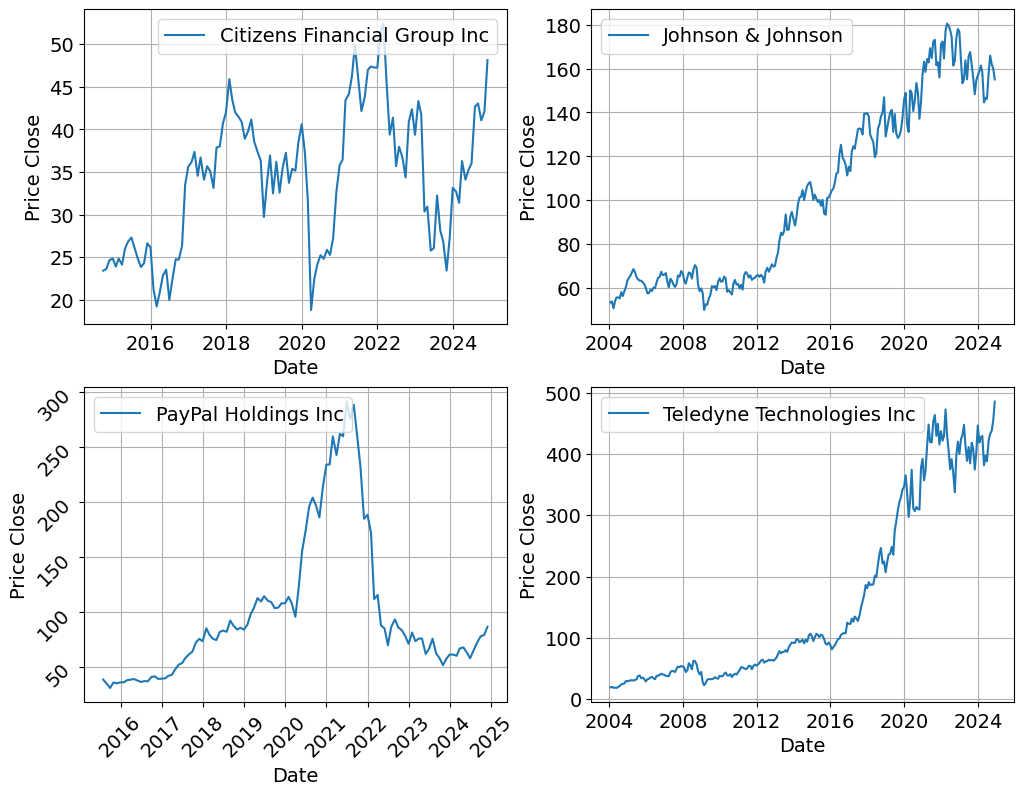

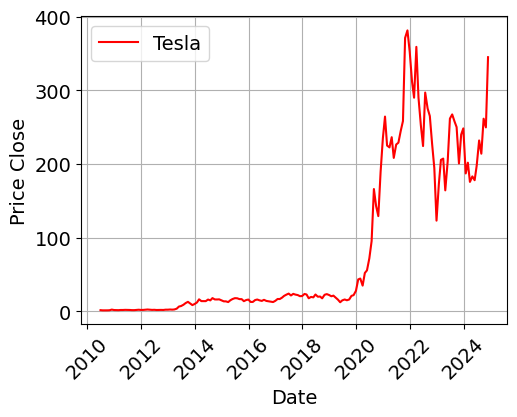

In [5]:
f, axes = plt.subplots(2, 2,figsize=(12,9))
sns.lineplot(x="Date",y="Price Close",data=df_CFG, ax=axes[0,0],label="Citizens Financial Group Inc")
sns.lineplot(x="Date",y="Price Close",data=df_JNJ, ax=axes[0,1],label="Johnson & Johnson")
sns.lineplot(x="Date",y="Price Close",data=df_PYPL, ax=axes[1,0],label="PayPal Holdings Inc")
sns.lineplot(x="Date",y="Price Close",data=df_TDY, ax=axes[1,1],label="Teledyne Technologies Inc")
axes[1,0].tick_params(rotation=45)
axes[1,0].grid()
axes[0,1].grid()
axes[0,0].grid()
plt.tight_layout
plt.grid()
plt.figure(figsize=(5.5,4))
sns.lineplot(x="Date",y="Price Close",data=df_TSLA,c="r",label="Tesla")
plt.grid()
plt.tight_layout
plt.xticks(rotation=45)
plt.legend()

In [6]:
df_price_close= pd.DataFrame({"Close TSLA":df_TSLA["Price Close"].values})
df_price_close["Close TDY"] = df_TDY["Price Close"].values
df_price_close["Close CFG"] = df_CFG["Price Close"].values
df_price_close["Close JNJ"] = df_JNJ["Price Close"].values
df_price_close["Close PYPL"] = df_PYPL["Price Close"].values

df_price_close

,Close TSLA,Close TDY,Close CFG,Close JNJ,Close PYPL
0,NaN,19.25,NaN,53.42,NaN
1,NaN,20.26,NaN,53.91,NaN
2,NaN,18.70,NaN,50.72,NaN
3,NaN,18.98,NaN,54.03,NaN
4,NaN,18.42,NaN,55.71,NaN
...,...,...,...,...,...
246,232.07,421.86,42.67,157.85,65.78
247,214.11,432.80,43.05,165.86,72.43
248,261.63,437.66,41.07,162.06,78.03
249,249.85,455.32,42.12,159.86,79.30


Creo un dataframe contenente il Close Price per le stock

In [7]:
df_price_close= pd.DataFrame({"Close TSLA":df_TSLA["Price Close"].values})
df_price_close["Close TDY"] = df_TDY["Price Close"].values
df_price_close["Close CFG"] = df_CFG["Price Close"].values
df_price_close["Close JNJ"] = df_JNJ["Price Close"].values
df_price_close["Close PYPL"] = df_PYPL["Price Close"].values

df_price_close

,Close TSLA,Close TDY,Close CFG,Close JNJ,Close PYPL
0,NaN,19.25,NaN,53.42,NaN
1,NaN,20.26,NaN,53.91,NaN
2,NaN,18.70,NaN,50.72,NaN
3,NaN,18.98,NaN,54.03,NaN
4,NaN,18.42,NaN,55.71,NaN
...,...,...,...,...,...
246,232.07,421.86,42.67,157.85,65.78
247,214.11,432.80,43.05,165.86,72.43
248,261.63,437.66,41.07,162.06,78.03
249,249.85,455.32,42.12,159.86,79.30


Creo un dataframe contenente i monthly per le stock

In [8]:
df_return_month = pd.DataFrame({"Close TSLA":df_TSLA["1 Month Total Return"].values})
df_return_month["Close TDY"] = df_TDY["1 Month Total Return"].values
df_return_month["Close CFG"] = df_CFG["1 Month Total Return"].values
df_return_month["Close JNJ"] = df_JNJ["1 Month Total Return"].values
df_return_month["Close PYPL"] = df_PYPL["1 Month Total Return"].values

df_return_month

,Close TSLA,Close TDY,Close CFG,Close JNJ,Close PYPL
0,NaN,2.122016,NaN,3.406891,NaN
1,NaN,4.432990,NaN,0.476836,NaN
2,NaN,-7.699901,NaN,-5.917270,NaN
3,NaN,0.264131,NaN,7.159857,NaN
4,NaN,-2.950474,NaN,3.648382,NaN
...,...,...,...,...,...
246,17.278148,8.732409,19.594782,7.998084,13.355161
247,-7.739044,2.593277,0.890555,5.874022,10.109456
248,22.194199,1.122921,-4.599303,-2.291089,7.731603
249,-4.502542,4.035096,3.565364,-1.357522,1.627579


Importante controllare le date di inizio e fine del dataset per capire se sono coerenti/compatibili, se ci interessa. Oltrettutto vedere come cambiano le correlazioni droppando i Nan

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

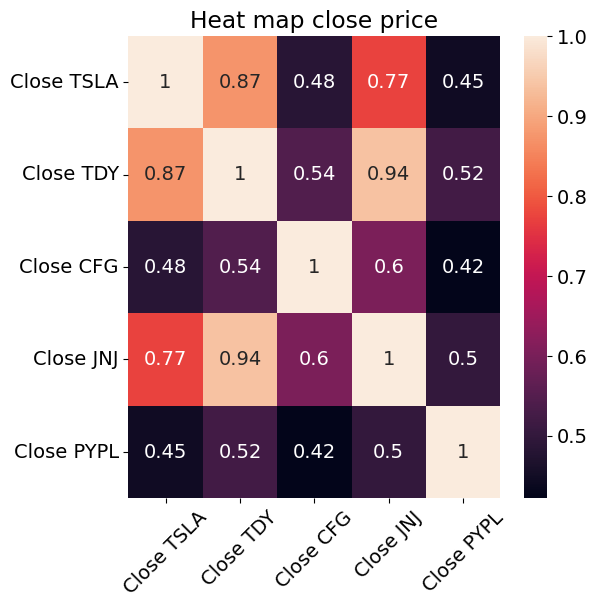

In [9]:
plt.figure(figsize=(6,6))
plt.title("Heat map close price")
sns.heatmap( df_price_close.corr(numeric_only=True),annot=True)
plt.xticks(rotation=45)
plt.tight_layout

Matrici di covaranza e correlazione per il close price
Matrici inverse

In [10]:
cov_close = df_price_close.cov(numeric_only=True).values
inv_corr_close = np.linalg.inv(df_price_close.corr(numeric_only=True).values)
inv_cov_close = np.linalg.inv(cov_close)

Matrici di covaranza e correlazione per il monthly
Matrici inverse

In [11]:
cov_mon = df_return_month.cov(numeric_only=True).values
inv_corr_mon = np.linalg.inv(df_return_month.corr(numeric_only=True).values)
inv_cov_mon = np.linalg.inv(cov_mon)

altre heat maps

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

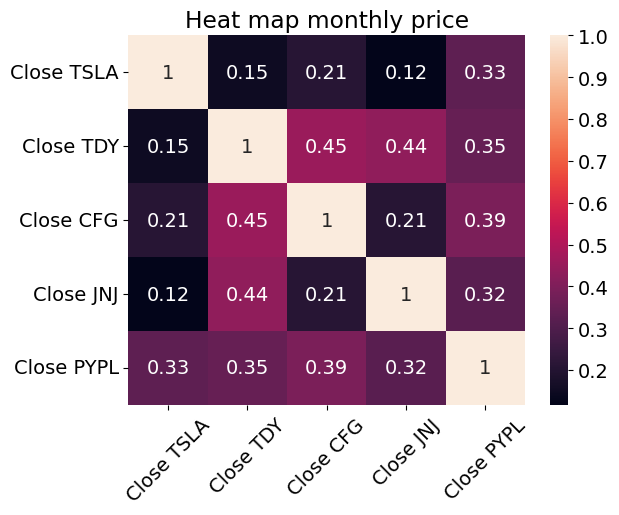

In [17]:
plt.title("Heat map monthly price")
sns.heatmap(df_return_month.corr(numeric_only=True),annot=True)
plt.xticks(rotation=45)
plt.tight_layout

## Punto 2

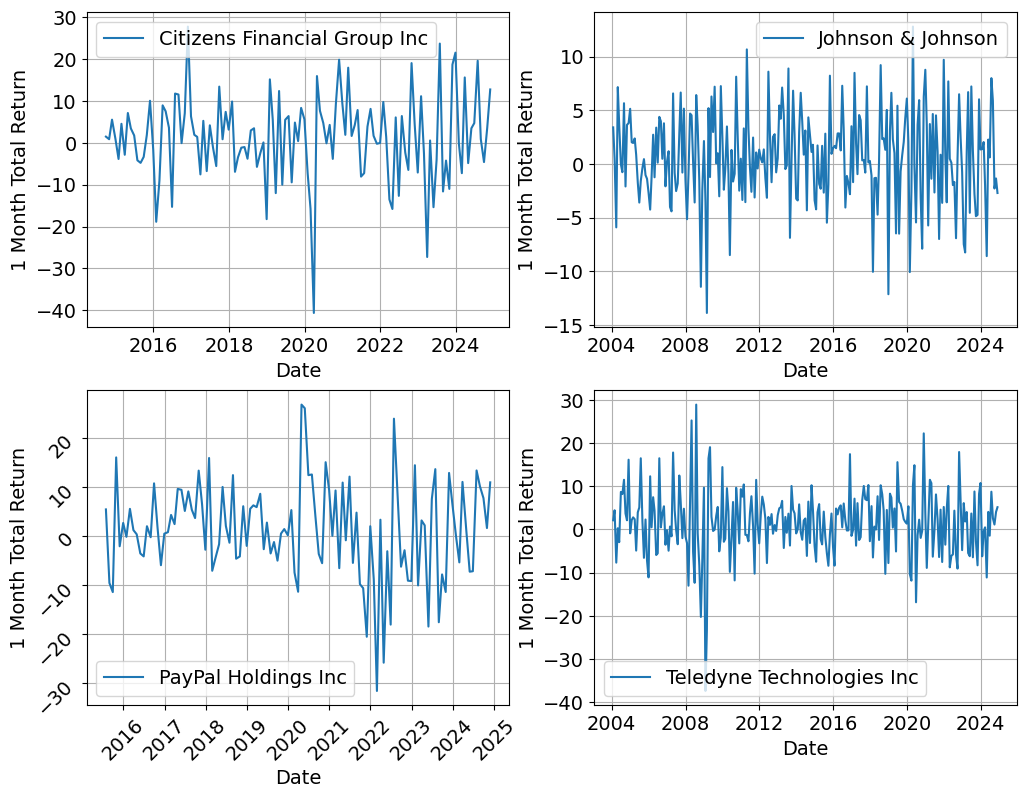

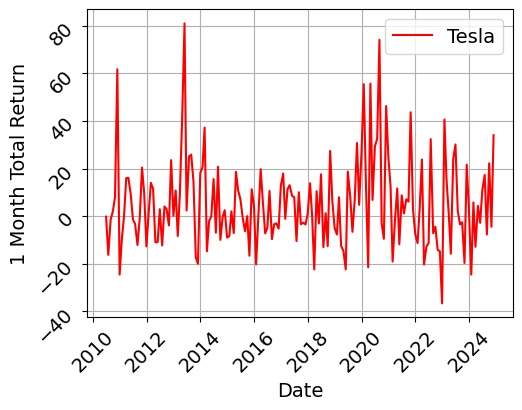

In [13]:
f, axes = plt.subplots(2, 2,figsize=(12,9))
sns.lineplot(x="Date",y="1 Month Total Return",data=df_CFG, ax=axes[0,0],label="Citizens Financial Group Inc")
sns.lineplot(x="Date",y="1 Month Total Return",data=df_JNJ, ax=axes[0,1],label="Johnson & Johnson")
sns.lineplot(x="Date",y="1 Month Total Return",data=df_PYPL, ax=axes[1,0],label="PayPal Holdings Inc")
sns.lineplot(x="Date",y="1 Month Total Return",data=df_TDY, ax=axes[1,1],label="Teledyne Technologies Inc")
axes[1,0].tick_params(rotation=45)
axes[1,0].grid()
axes[0,1].grid()
axes[0,0].grid()
plt.tight_layout
plt.grid()
plt.figure(figsize=(5.5,4))
sns.lineplot(x="Date",y="1 Month Total Return",data=df_TSLA,c="r",label="Tesla")
plt.grid()
plt.tick_params(rotation=45)
plt.tight_layout
plt.legend()

Per fare il moving average posso utilizzare una funzione di pandas che mi fa direttamente il calcolo, la documentazione a riguardo dice che.....

Text(0, 0.5, 'Exponential moving Average')

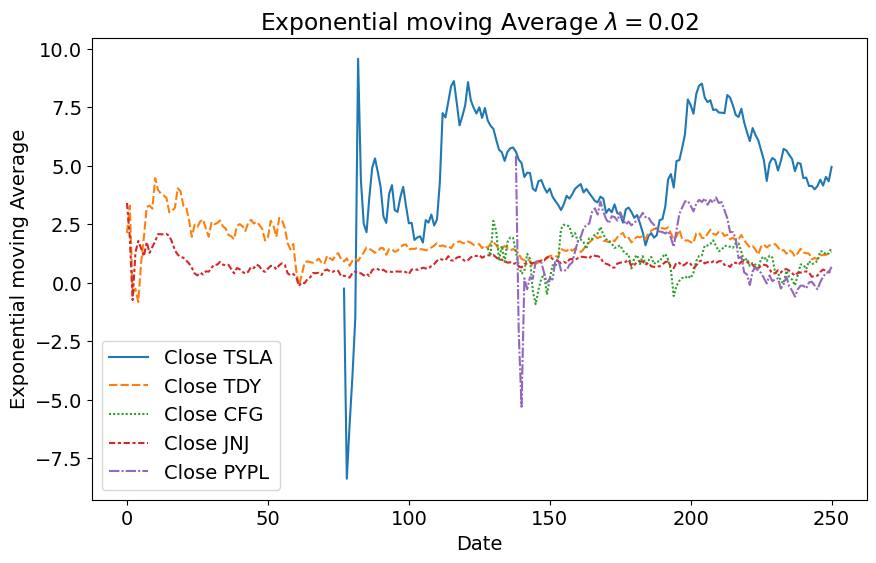

In [14]:
lam = 0.02
ema_df = df_return_month.ewm(alpha=lam).mean()
plt.figure(figsize=(10,6))
plt.title(r"Exponential moving Average $\lambda = 0.02$")
sns.lineplot(data=ema_df)
plt.xlabel("Date")
plt.ylabel("Exponential moving Average")

## Punto 3

Sappiamo dalla teoria di markovitz senza risk free che
$$\mu_p = \sum_i w_i\mu_i\,,\quad \sigma^2_p = \sum_{i,j}\sigma_{ij} w_i w_j$$

### Questa è risk-free va modificata per r_f nei prossimi days lo faccio

In [15]:
Rf = 0.03/12 #0.03 == annual return, ma noi vogliamo la monthly quindi divido per 12

mu = df_return_month.mean()

excess_returns = mu - Rf

numeratore = np.dot(inv_cov_mon, excess_returns)
denominatore = np.sum(numeratore)
weights = numeratore/denominatore

print("Pesi portforlio ottimale:", weights)

Pesi portforlio ottimale: [ 0.29575707  0.41672892  0.01278935  0.35503701 -0.08031235]


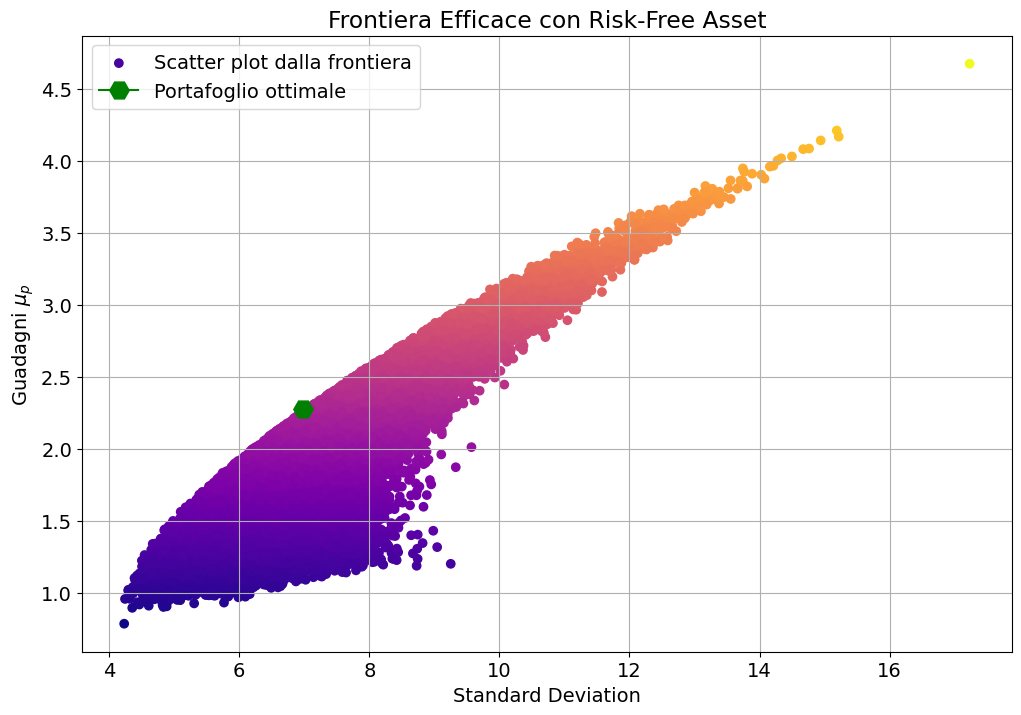

In [16]:
sigma_p = np.linspace(0,10,100) 

"""e = np.ones(len(weights))
A = inv_cov @ mu @ mu
B = inv_cov @ mu @ e
D = inv_cov @ e @ e
det = A*D - B*B
lam = 1
gamma = 1"""

mu_opt = mu@weights
sigma_opt = np.sqrt(cov_mon @ weights @ weights)

mu_bullet = []
sigma_bullet = []

for i in range(100000):
    random_weight = np.random.uniform(0, 0.5, 5)
    random_weight /= np.sum(random_weight)
    mu_bullet.append(random_weight@mu)
    sigma_bullet.append(np.sqrt(cov_mon@random_weight@random_weight))

plt.figure(figsize=(12,8))
plt.title("Frontiera Efficace con Risk-Free Asset")

plt.scatter(sigma_bullet,mu_bullet,cmap='plasma',c=mu_bullet,marker='o', label = "Scatter plot dalla frontiera")
plt.plot(sigma_opt,mu_opt,color="g",marker="H",markersize=14,label = "Portafoglio ottimale")
plt.xlabel("Standard Deviation")
plt.ylabel(r"Guadagni $\mu_p $")
"""plt.xlim(3,10)
plt.ylim(0,4)"""
plt.legend()
plt.grid(True)
plt.show()



## Punto 4

## Punto 5

## Punto 6

## Punto 7

## Punto 8